In [1]:
import torch
from data_loader import CustomDataLoader
from torch.utils.data import DataLoader
import ukis_metrics.seg_metrics as segm
from inference_utils import get_model, evaluate_model, plot_predictions

import warnings
warnings.filterwarnings('ignore')

### Results with all available channels (R, G, B, NIR, SWIR1, SWIR2)

In [2]:
model_ckpt = './networks/2024_05_01-10_54_41_encoder_efficientnet-b0_weights_imagenet_epochs_100_batchsize_16_lr_0.001/model_0.19832_val_avg.pt'
model, channels = get_model(model_ckpt)

Model parameters:
{'epochs': 100, 'batch_size': 16, 'lr': 0.001, 'encoder': 'efficientnet-b0', 'weights': 'imagenet', 'model_ckpt_path': './networks', 'data_path': '../data_prepped', 'channels': 'r.g.b.nir.swir1.swir2'}


In [3]:
# Get the test dataset
data_path = '../data_prepped'
image_path = data_path + '/{}/img/*'
mask_path = data_path + '/{}/msk/*'
 
# Use custom data loaders for the dataset
test_dataset = CustomDataLoader(image_path.format('test'), mask_path.format('test'), channels = channels)
test_loader = DataLoader(dataset = test_dataset, batch_size = 8, shuffle = False, num_workers = 8)

In [4]:
images, masks, preds = evaluate_model(test_loader, model, thresholds = [0.4]) #[0.1, 0.2, 0.4, 0.8, 1.0]

  3%|██▍                                                                             | 100/3211 [00:19<10:13,  5.07it/s]


0.4 {'iou': 0.9695, 'recall': 0.9772, 'precision': 0.9918, 'acc': 0.9999, 'F1': 0.9845, 'kappa': 0.9844}


In [5]:
idx = 10
images_, masks_, preds_ = images[0.4][idx:idx+10], masks[0.4][idx:idx+10], preds[0.4][idx:idx+10]

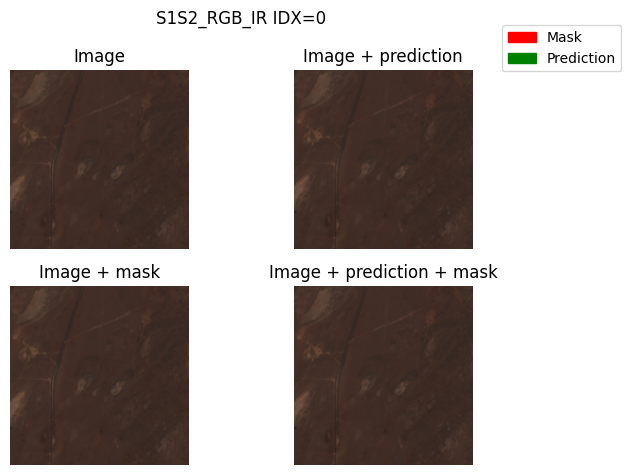

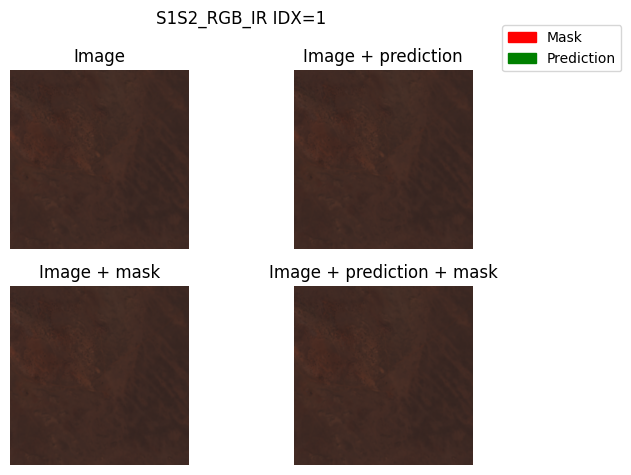

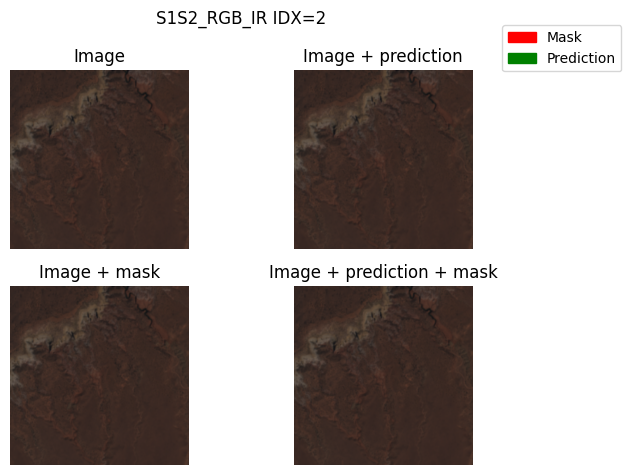

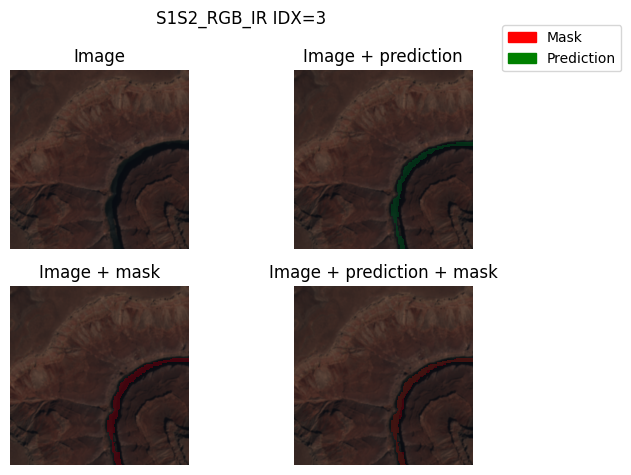

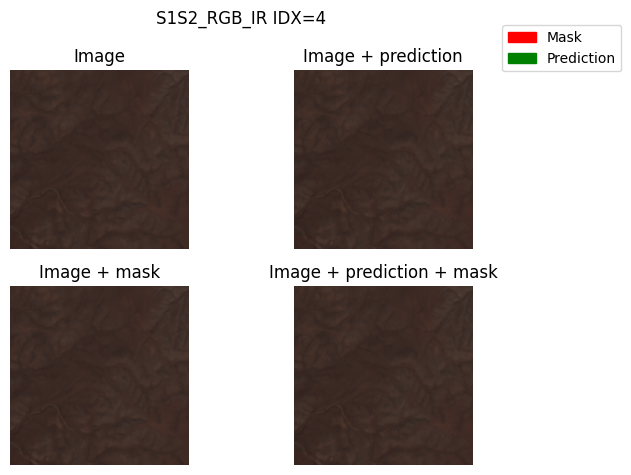

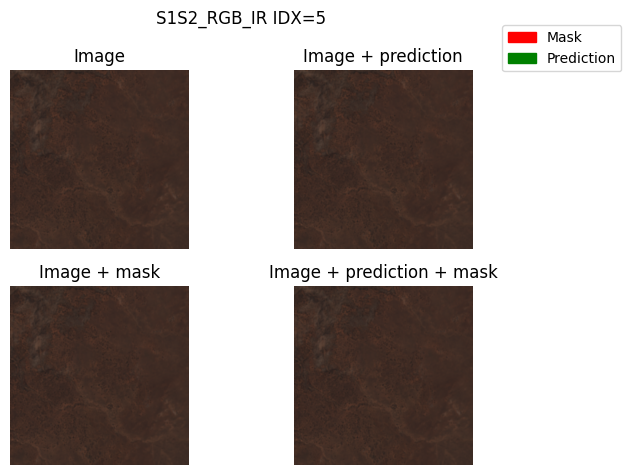

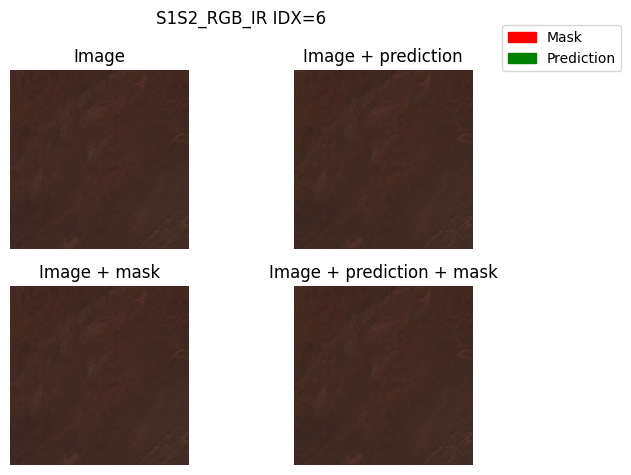

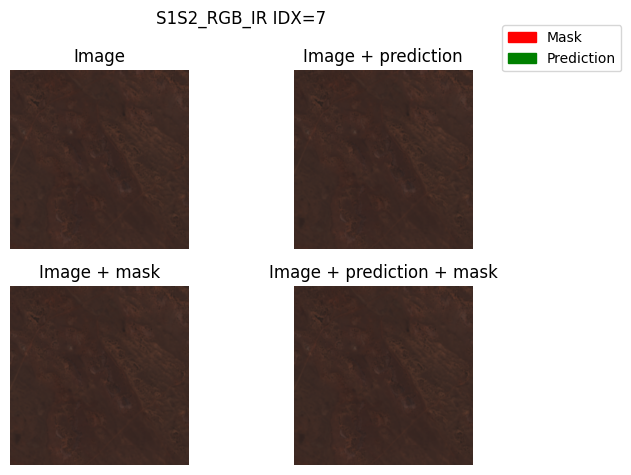

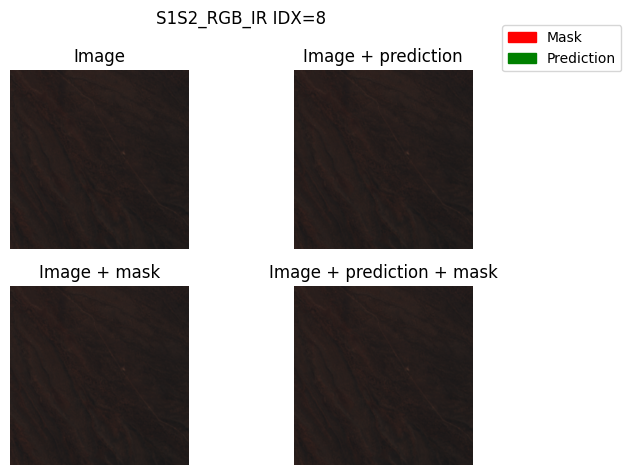

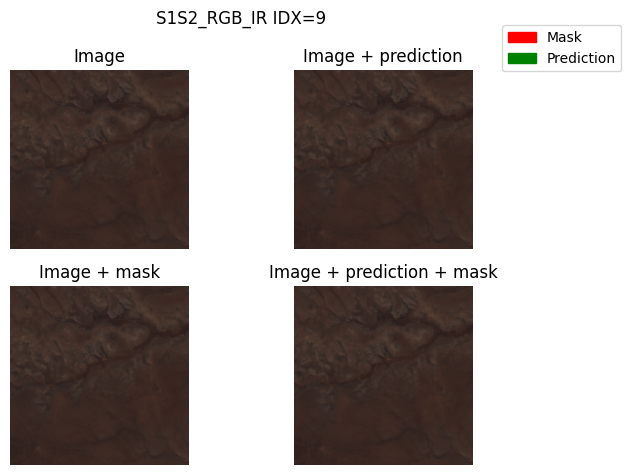

In [6]:
plot_predictions(images_, masks_, preds_, 'S1S2_RGB_IR')

### With only RGB channels

In [7]:
model_ckpt = './networks/2024_04_16-16_37_36_encoder_efficientnet-b0_weights_imagenet_epochs_100_batchsize_16_lr_0.001/model_0.38835_val_avg.pt'
model, channels = get_model(model_ckpt)

Model parameters:
{'epochs': 100, 'batch_size': 16, 'lr': 0.001, 'encoder': 'efficientnet-b0', 'weights': 'imagenet', 'model_ckpt_path': './networks', 'data_path': '../data_prepped', 'channels': 'r.g.b'}


In [8]:
# Get the test dataset
data_path = '../data_prepped'
image_path = data_path + '/{}/img/*'
mask_path = data_path + '/{}/msk/*'
 
# Use custom data loaders for the dataset
test_dataset = CustomDataLoader(image_path.format('test'), mask_path.format('test'), channels = channels)
test_loader = DataLoader(dataset = test_dataset, batch_size = 8, shuffle = False, num_workers = 8)

In [9]:
images, masks, preds = evaluate_model(test_loader, model, thresholds = [0.1, 0.2, 0.4, 0.8, 1.0])

  3%|██▍                                                                             | 100/3211 [00:12<06:32,  7.93it/s]


0.1 {'iou': 0.2027, 'recall': 0.9227, 'precision': 0.2062, 'acc': 0.9863, 'F1': 0.3371, 'kappa': 0.333}


  3%|██▍                                                                             | 100/3211 [00:14<07:21,  7.05it/s]


0.2 {'iou': 0.2283, 'recall': 0.9075, 'precision': 0.2338, 'acc': 0.9884, 'F1': 0.3718, 'kappa': 0.368}


  3%|██▍                                                                             | 100/3211 [00:14<07:37,  6.79it/s]


0.4 {'iou': 0.2722, 'recall': 0.8343, 'precision': 0.2878, 'acc': 0.9916, 'F1': 0.428, 'kappa': 0.4247}


  3%|██▍                                                                             | 100/3211 [00:14<07:44,  6.70it/s]


0.8 {'iou': 0.2681, 'recall': 0.6832, 'precision': 0.3061, 'acc': 0.993, 'F1': 0.4228, 'kappa': 0.4198}


  3%|██▍                                                                             | 100/3211 [00:14<07:32,  6.87it/s]

1.0 {'iou': 0.2441, 'recall': 0.5465, 'precision': 0.3061, 'acc': 0.9936, 'F1': 0.3925, 'kappa': 0.3895}


In [20]:
idx = 60
images_, masks_, preds_ = images[0.4][idx:idx+10], masks[0.4][idx:idx+10], preds[0.4][idx:idx+10]

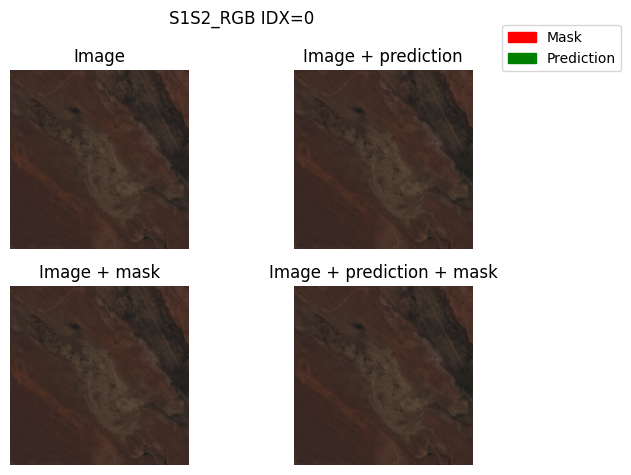

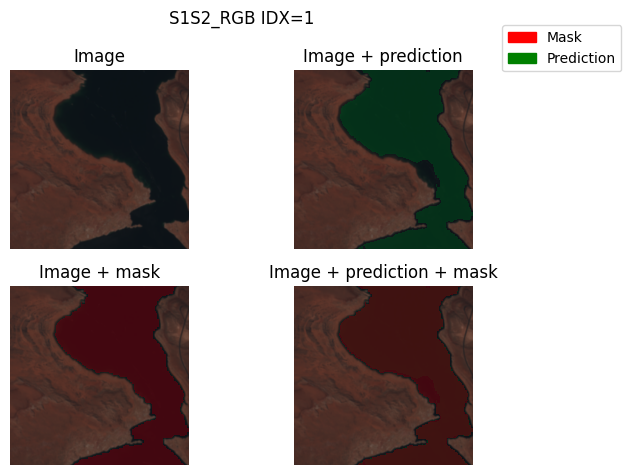

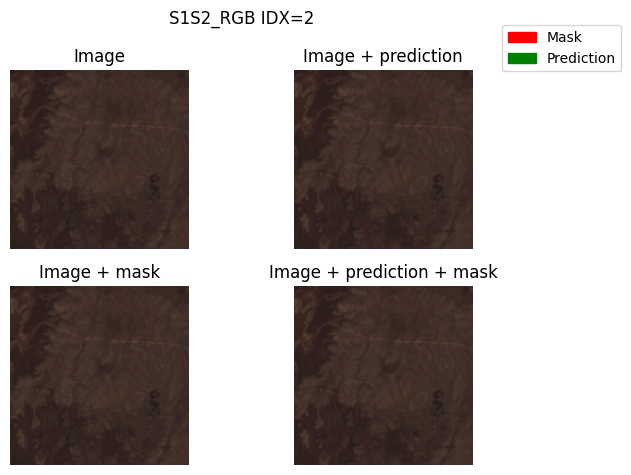

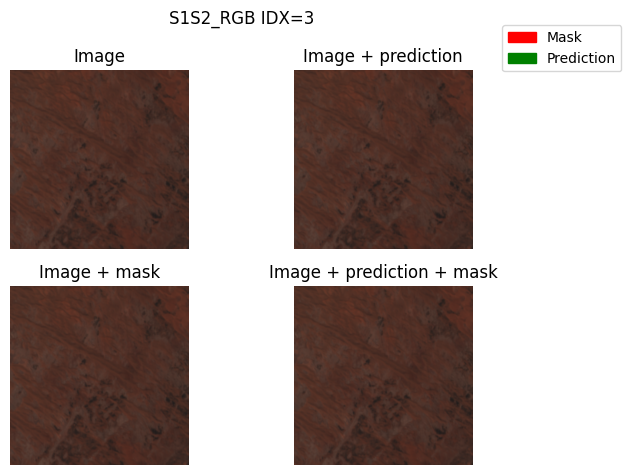

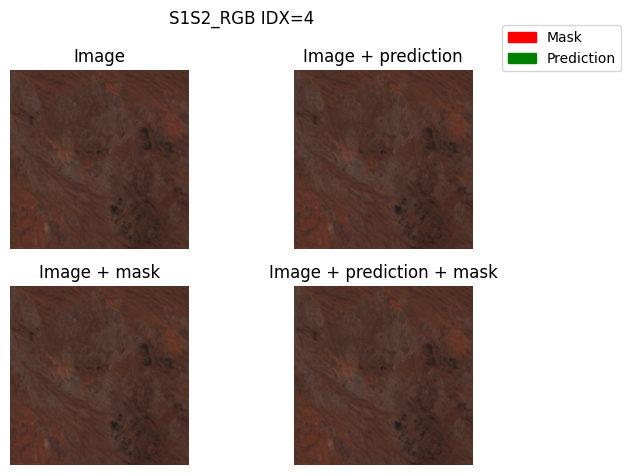

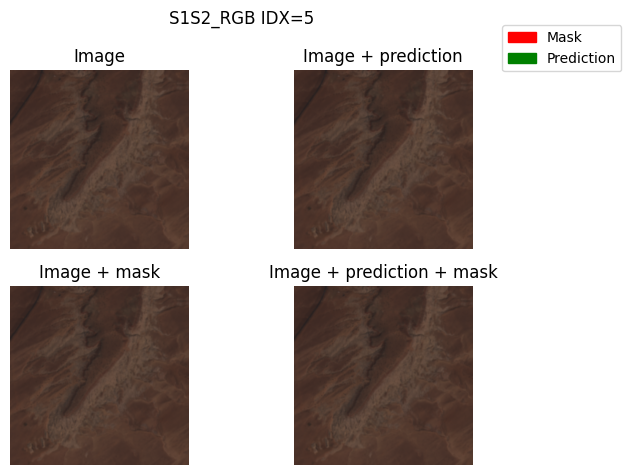

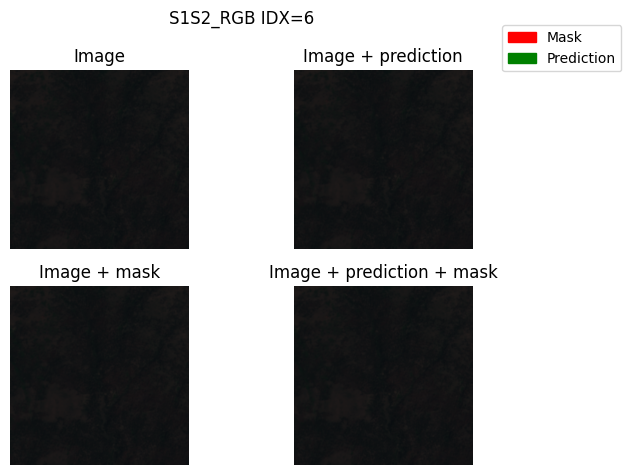

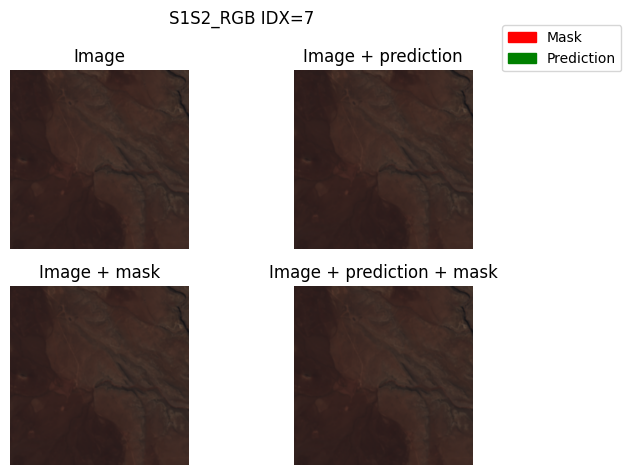

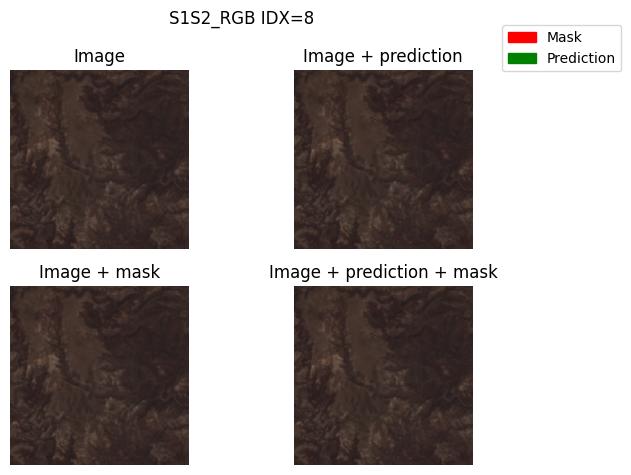

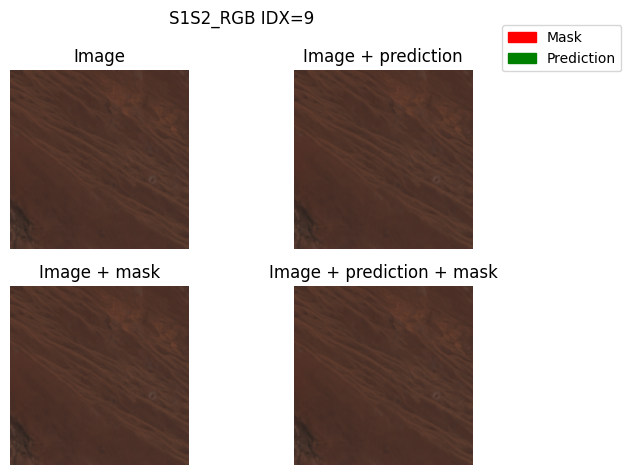

In [21]:
plot_predictions(images_, masks_, preds_, 'S1S2_RGB')